Introduction

# Importing the necessary libraries

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, make_scorer

# LOADING THE DATASET

In [1]:
# Load the datasets
ratings_df = pd.read_csv('ml-latest-small/ratings.csv')
tags_df = pd.read_csv('ml-latest-small/tags.csv')
movies_df = pd.read_csv('ml-latest-small/movies.csv')
links_df = pd.read_csv('ml-latest-small/links.csv')

# Merge ratings and movies
ratings_movies_df = pd.merge(ratings_df, movies_df, on='movieId', how='left')

# Merge tags with the previous merge result
ratings_movies_tags_df = pd.merge(ratings_movies_df, tags_df, on=['movieId', 'userId'], how='left')

# Merge the links if needed (optional, usually for external database or additional info)
final_merged_df = pd.merge(ratings_movies_tags_df, links_df, on='movieId', how='left')

# Check the merged dataset
print(final_merged_df.info())
print(final_merged_df.head())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 102677 entries, 0 to 102676
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   userId       102677 non-null  int64  
 1   movieId      102677 non-null  int64  
 2   rating       102677 non-null  float64
 3   timestamp_x  102677 non-null  int64  
 4   title        102677 non-null  object 
 5   genres       102677 non-null  object 
 6   tag          3476 non-null    object 
 7   timestamp_y  3476 non-null    float64
 8   imdbId       102677 non-null  int64  
 9   tmdbId       102664 non-null  float64
dtypes: float64(3), int64(4), object(3)
memory usage: 8.6+ MB
None
   userId  movieId  rating  timestamp_x                        title  \
0       1        1     4.0    964982703             Toy Story (1995)   
1       1        3     4.0    964981247      Grumpier Old Men (1995)   
2       1        6     4.0    964982224                  Heat (1995)   
3       1       47

# EDA

# The fisrt five entries in the dataset

In [3]:
# Load the dataset
file_path = 'merged_movie_data.csv'
movie_data = pd.read_csv(file_path)

# Display the first few rows of the dataset
movie_data.head()


,userId,movieId,rating,timestamp_x,title,genres,tag,timestamp_y,imdbId,tmdbId
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,NaN,NaN,114709,862.0
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance,NaN,NaN,113228,15602.0
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller,NaN,NaN,113277,949.0
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,NaN,NaN,114369,807.0
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,NaN,NaN,114814,629.0


# General information about the dataset

In [4]:
# General information about the dataset
movie_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102677 entries, 0 to 102676
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   userId       102677 non-null  int64  
 1   movieId      102677 non-null  int64  
 2   rating       102677 non-null  float64
 3   timestamp_x  102677 non-null  int64  
 4   title        102677 non-null  object 
 5   genres       102677 non-null  object 
 6   tag          3476 non-null    object 
 7   timestamp_y  3476 non-null    float64
 8   imdbId       102677 non-null  int64  
 9   tmdbId       102664 non-null  float64
dtypes: float64(3), int64(4), object(3)
memory usage: 7.8+ MB


# Statistical summary for numerical columns

In [5]:
# Statistical summary for numerical columns
movie_data.describe()

,userId,movieId,rating,timestamp_x,timestamp_y,imdbId,tmdbId
count,102677.000000,102677.000000,102677.000000,1.026770e+05,3.476000e+03,1.026770e+05,102664.000000
mean,327.761933,19742.712623,3.514813,1.209495e+09,1.323525e+09,3.564994e+05,20476.871289
std,183.211289,35884.400990,1.043133,2.170117e+08,1.731554e+08,6.295717e+05,54097.633332
min,1.000000,1.000000,0.500000,8.281246e+08,1.137179e+09,4.170000e+02,2.000000
25%,177.000000,1199.000000,3.000000,1.019138e+09,1.138032e+09,9.971000e+04,710.000000
50%,328.000000,3005.000000,3.500000,1.186590e+09,1.279956e+09,1.188420e+05,6950.000000
75%,477.000000,8366.000000,4.000000,1.439916e+09,1.498457e+09,3.172480e+05,11673.000000
max,610.000000,193609.000000,5.000000,1.537799e+09,1.537099e+09,8.391976e+06,525662.000000


# MISSING VALUES

In [6]:
# Check for missing values in each column
missing_values = movie_data.isnull().sum()

# Display missing values
missing_values

userId             0
movieId            0
rating             0
timestamp_x        0
title              0
genres             0
tag            99201
timestamp_y    99201
imdbId             0
tmdbId            13
dtype: int64

# Rating Distribution


examining how movie ratings are distributed using a histogram

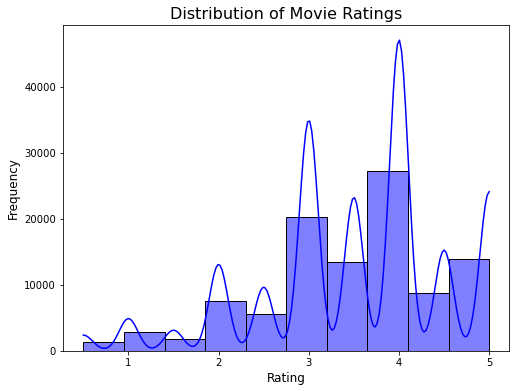

In [9]:
# Plot the distribution of movie ratings
plt.figure(figsize=(8, 6))
sns.histplot(movie_data['rating'], bins=10, kde=True, color='blue')
plt.title('Distribution of Movie Ratings', fontsize=16)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

# Rating Distribution by Genre

Analyzing the distribution of ratings for each genre.

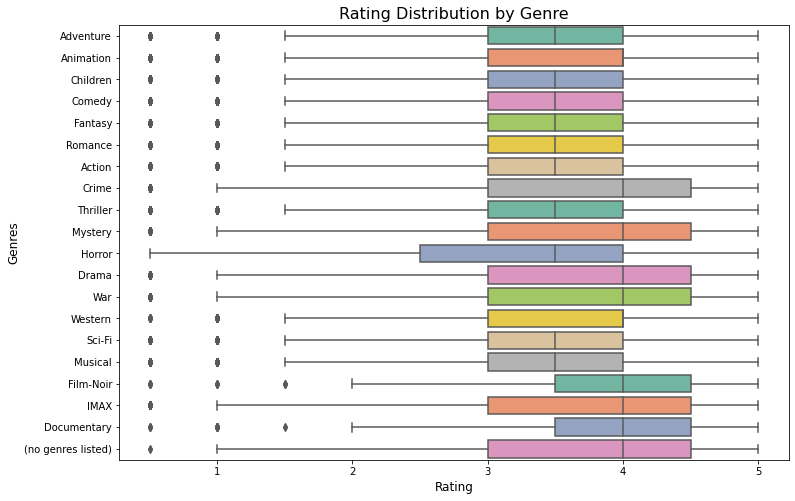

In [10]:
# Explode the genres and assign ratings to each genre
exploded_genres = movie_data[['rating', 'genres']].copy()
exploded_genres = exploded_genres.assign(genres=exploded_genres['genres'].str.split('|')).explode('genres')

# Plot rating distribution for each genre
plt.figure(figsize=(12, 8))
sns.boxplot(x='rating', y='genres', data=exploded_genres, palette='Set2')
plt.title('Rating Distribution by Genre', fontsize=16)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Genres', fontsize=12)
plt.show()

# Correlation Analysis

Visualizing the correlation between numerical features such as rating, imdbId, and tmdbId.

This will help us understand the relationships between the numerical features.

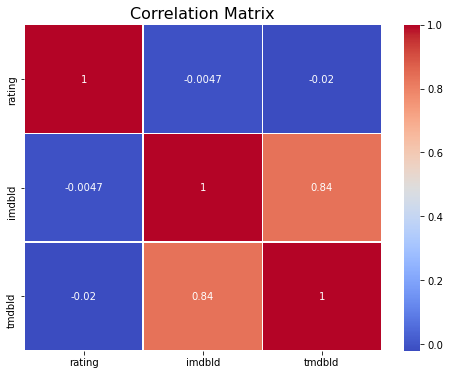

In [11]:
# Calculate correlation matrix
correlation_matrix = movie_data[['rating', 'imdbId', 'tmdbId']].corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix', fontsize=16)
plt.show()

# Top 10 Active Users

Identifing users who have rated the most movies.

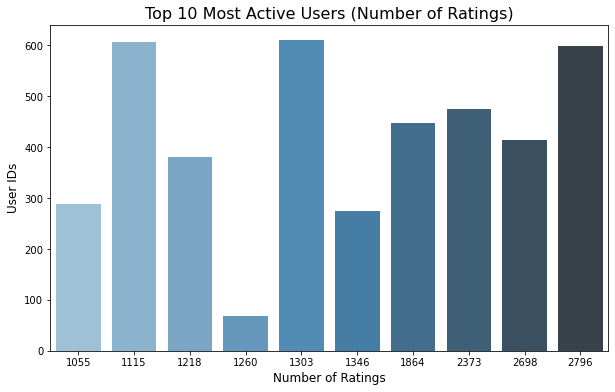

In [12]:
# Count the number of ratings per user
top_users = movie_data['userId'].value_counts().head(10)

# Plot the top 10 active users
plt.figure(figsize=(10, 6))
sns.barplot(x=top_users.values, y=top_users.index, palette='Blues_d')
plt.title('Top 10 Most Active Users (Number of Ratings)', fontsize=16)
plt.xlabel('Number of Ratings', fontsize=12)
plt.ylabel('User IDs', fontsize=12)
plt.show()


# Most Rated Movies

Identifing which movies have received the most ratings.

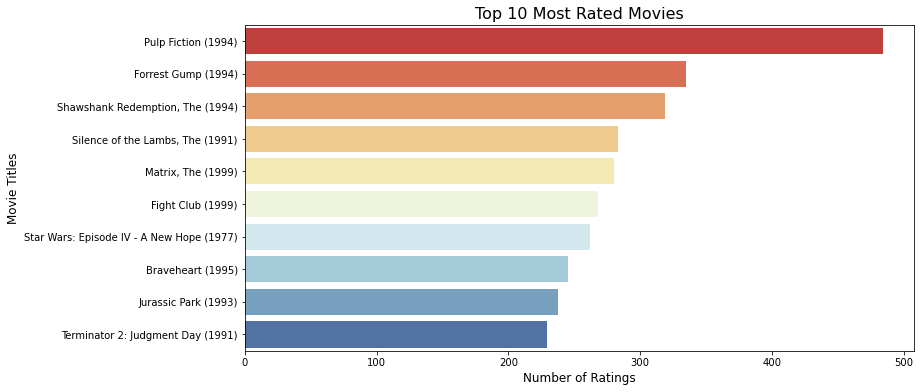

In [13]:
# Count the number of ratings per movie
top_movies = movie_data['title'].value_counts().head(10)

# Plot the top 10 most rated movies
plt.figure(figsize=(12, 6))
sns.barplot(x=top_movies.values, y=top_movies.index, palette='RdYlBu')
plt.title('Top 10 Most Rated Movies', fontsize=16)
plt.xlabel('Number of Ratings', fontsize=12)
plt.ylabel('Movie Titles', fontsize=12)
plt.show()

# Data Cleaning

Here we will handle missing values as well dropping uncessary columns with features that have useful information for our modelling.

A closer look on the missing values above, the data have no missing values other than on the feautre that are not useful on our modeling.

Therefore by dropping uncessary data, we will have dealt with the missing values

In [43]:
#creating a new dataset with the necessary features.

df = movie_data[['userId','movieId', 'rating', 'title']]

df.info

<bound method DataFrame.info of         userId  movieId  rating                           title
0            1        1     4.0                Toy Story (1995)
1            1        3     4.0         Grumpier Old Men (1995)
2            1        6     4.0                     Heat (1995)
3            1       47     5.0     Seven (a.k.a. Se7en) (1995)
4            1       50     5.0      Usual Suspects, The (1995)
...        ...      ...     ...                             ...
102672     610   166534     4.0                    Split (2017)
102673     610   168248     5.0   John Wick: Chapter Two (2017)
102674     610   168250     5.0                  Get Out (2017)
102675     610   168252     5.0                    Logan (2017)
102676     610   170875     3.0  The Fate of the Furious (2017)

[102677 rows x 4 columns]>

# Creating a utility matrix

In [46]:
# Creating a utility matrix where users are rows, movies are columns, and ratings are values
user_movie_matrix = df.pivot_table(index='userId', columns='title', values='rating')

# Filling missing ratings with 0 for simplicity (or we could use other imputation methods)
user_movie_matrix.fillna(0, inplace=True)

# Display the utility matrix
user_movie_matrix.head()

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Collaborative Filtering: Using Matrix Factorization (SVD)

In [47]:
# Keep only relevant columns for the SVD algorithm
df = df[['userId', 'movieId', 'rating']]

In [72]:
#Prepare the data for the Surprise library
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)

In [74]:
param_grid = {'n_factors': [10, 30, 50, 80, 100], 'lr_all': [0.002, 0.006, 0.018, 0.054, 0.10]}

gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(data)

TypeError: __init__() got an unexpected keyword argument 'measures'